# Human Face Generator using GANs

A generative adversarial network is a class of machine learning frameworks designed by Ian Goodfellow and his colleagues in 2014.
[Paper](https://papers.nips.cc/paper/2014/file/5ca3e9b122f61f8f06494c97b1afccf3-Paper.pdf)

Generative adversarial networks (GANs) are algorithmic architectures that use two neural networks, pitting one against the other (thus the “adversarial”) in order to generate new, synthetic instances of data that can pass for real data. They are used widely in image ,video  and voice generation.

* The generator learns to generate plausible data. The generated instances become negative training examples for the discriminator.

* The discriminator learns to distinguish the generator's fake data from real data. The discriminator penalizes the generator for producing implausible results.

![Gans Architecture](https://miro.medium.com/max/3286/1*Pvn9wuntqx3UMsNGS-FAvg.png)

But How these two models can help generating new faces which do not exist?

* We feed the generator with random input and it returns an image.

* The output of the generated which is combined with real images. This images both *(generated and real)* are labeled as (fake = 0 and real =1).

* The discriminator takes in both real and fake images and returns the probabilities of the genuinity of the image.

Thus have two feedback loop:

* The discriminator is in a feedback loop with the ground truth of the images, which we know.

* The generator is in a feedback loop with the discriminator.

Now let's code !

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from tqdm import tqdm
from PIL import Image as Img
import tensorflow as tf
from keras import Input
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from keras.models import Model
from keras.optimizers import RMSprop
from matplotlib import pyplot as plt

# Data Set

We will use a celebrity images dataset [Kaggle Dataset](https://www.kaggle.com/jessicali9530/celeba-dataset)


In [19]:
folder_data = '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/'

IMAGES_COUNT = 10000

ORIG_WIDTH = 178
ORIG_HEIGHT = 208
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2

WIDTH = 128
HEIGHT = 128

crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)

images = []
for pic_file in tqdm(os.listdir(folder_data)[:IMAGES_COUNT]):
    pic = Img.open(folder_data + pic_file).crop(crop_rect)
    pic.thumbnail((WIDTH, HEIGHT), Img.ANTIALIAS)
    images.append(np.uint8(pic))
images= np.array(images)

100%|██████████| 10000/10000 [00:22<00:00, 435.64it/s]


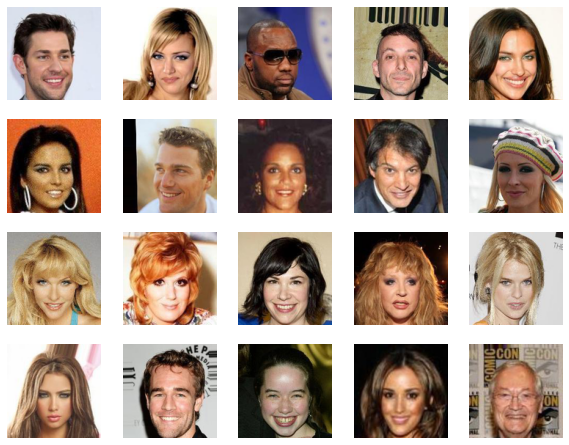

In [10]:
plt.figure(1, figsize=(10, 10))
for i in range(20):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

# The generator

In [11]:
# The size of the generator input
LATENT_DIM = 32
CHANNELS = 3

def create_generator():
    
    model = tf.keras.Sequential()
    model.add(Input(shape=(LATENT_DIM, )))
    
    model.add(Dense(128 * 16 * 16))
    model.add(LeakyReLU())
    model.add(Reshape((16, 16, 128)))

    
    model.add(Conv2D(256, 5, padding='same'))
    model.add(LeakyReLU())
              
    model.add(Conv2DTranspose(256, 4,strides=2, padding='same'))
    model.add(LeakyReLU())
      
    model.add(Conv2DTranspose(256, 4,strides=2, padding='same'))
    model.add(LeakyReLU())
    
    model.add(Conv2DTranspose(256, 4,strides=2, padding='same'))
    model.add(LeakyReLU())
              
    model.add(Conv2D(512, 5, padding='same'))
    model.add(LeakyReLU())
              
    model.add(Conv2D(512, 5, padding='same'))
    model.add(LeakyReLU())
    
    model.add(Conv2D(CHANNELS, 7, activation='tanh', padding='same'))
    
    print(model.output_shape)
    assert model.output_shape == (None, 128, 128, 3)
              
    return model

# The Discriminator

In [12]:
def create_discriminator():
    
    model = tf.keras.Sequential()
    
    model.add( Input(shape=(128, 128, 3)) )
    
    model.add(Conv2D(256, 3))
    model.add(LeakyReLU())

    model.add(Conv2D(256, 4, strides=2))
    model.add(LeakyReLU())

    model.add(Conv2D(256, 4, strides=2))
    model.add(LeakyReLU())

    model.add(Conv2D(256, 4, strides=2))
    model.add(LeakyReLU())

    model.add(Conv2D(256, 4, strides=2))
    model.add(LeakyReLU())
    
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    discriminator = model

    optimizer = RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )

    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )
    
    assert model.input_shape == (None, 128, 128, 3)
    return discriminator

In [13]:
generator = create_generator()
generator.summary()

(None, 128, 128, 3)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 256)       1048832   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 

In [14]:
discriminator = create_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 126, 256)     7168      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 126, 126, 256)     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 62, 62, 256)       1048832   
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 62, 62, 256)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 256)       1048832   
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 30, 30, 256)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 256)      

Now let's link the two nets

In [15]:
gan_input = Input(shape=(LATENT_DIM, ))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

In [16]:
optimizer = RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')

The model risks to be heavy. let's check if the GPU is ready and warm enough to start working !

In [17]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Given the fact we're handling two nets, the trainng is quite unusal.
* As the generator improves with training, the discriminator performance gets worse because the discriminator can’t easily tell the difference between real and fake.
Let's start the training.

In [ ]:
import time
iters = 15000
batch_size = 16

RES_DIR = 'results'
FILE_PATH = '%s/generated_%d.png'

if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)
    
## generate random input
CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2

start = 0
d_losses = []
a_losses = []
images_saved = 0

for step in range(iters):
    
    start_time = time.time()
    
    ## generate random input
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    ## Generator == > Feed Forward using the random input
    generated = generator.predict(latent_vectors)
    ## Bath size of real images
    real = images[start:start + batch_size]
    ## Combine two sets [ Fake (genreated images) , real]
    combined_images = np.concatenate([generated, real])
    ## Add Labels : generated =  1 , real = 0
    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    
    labels += .05 * np.random.random(labels.shape)

    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)

    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    
    misleading_targets = np.zeros((batch_size, 1))
    
    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    
    a_losses.append(a_loss)

    start += batch_size
    if start > images.shape[0] - batch_size:
        start = 0

    if step % 50 == 49:
        gan.save_weights('/gan.h5')

        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))

        control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
        control_generated = generator.predict(control_vectors)
        for i in range(CONTROL_SIZE_SQRT ** 2):
            x_off = i % CONTROL_SIZE_SQRT
            y_off = i // CONTROL_SIZE_SQRT
            control_image[x_off * WIDTH:(x_off + 1) * WIDTH, y_off * HEIGHT:(y_off + 1) * HEIGHT, :] = control_generated[i, :, :, :]
        im = Img.fromarray(np.uint8(control_image * 255))#.save(StringIO(), 'jpeg')
        im.save(FILE_PATH % (RES_DIR, images_saved))
        images_saved += 1

        

50/15000: d_loss: 14.3556,  a_loss: 0.0032.  (1.1 sec)
100/15000: d_loss: 4.6716,  a_loss: 0.1316.  (1.2 sec)
150/15000: d_loss: 5.4844,  a_loss: 0.0189.  (1.2 sec)
200/15000: d_loss: 6.0524,  a_loss: 0.0558.  (1.2 sec)
250/15000: d_loss: 5.8226,  a_loss: 0.0048.  (1.2 sec)
300/15000: d_loss: 7.1113,  a_loss: 0.0007.  (1.2 sec)
350/15000: d_loss: 11.5955,  a_loss: 0.0001.  (1.2 sec)
400/15000: d_loss: 8.6647,  a_loss: 0.0017.  (1.2 sec)
450/15000: d_loss: 8.5147,  a_loss: 0.0002.  (1.3 sec)
500/15000: d_loss: 10.7191,  a_loss: 0.0001.  (1.2 sec)
550/15000: d_loss: 3.2265,  a_loss: 0.0130.  (1.2 sec)
600/15000: d_loss: 5.2968,  a_loss: 0.0020.  (1.2 sec)
650/15000: d_loss: 5.6449,  a_loss: 0.0011.  (1.2 sec)
700/15000: d_loss: 8.3632,  a_loss: 0.0001.  (1.2 sec)
750/15000: d_loss: 9.8708,  a_loss: 0.0000.  (1.2 sec)
800/15000: d_loss: 9.7623,  a_loss: 0.0000.  (1.2 sec)
850/15000: d_loss: 10.2051,  a_loss: 0.0000.  (1.2 sec)
900/15000: d_loss: 9.0967,  a_loss: 0.0000.  (1.3 sec)
950/150

* To use our model in production. We export the generator model and reuse it in the streamlit app developped [Link](https://gan-face-generator.herokuapp.com/)

In [ ]:
generator.save("my_model")